# Notebook 3

### In this notebook
1. Estimate transition kernel $K_{ij}$
2. Calculate transition lifetimes between disks $\tau_i$
3. Performe steady state flux calculation $q_i$
4. .....

### Import libraries

In [4]:
# python libs
import sys
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy

# BKit modules
from BKit.TransitionKernel import TransitionKernel
from BKit.KinSolvers import KineticsQK

### Load microstate labels of all short MDs

In [5]:
dat_path = '../output/'
print("reading inputs from " + dat_path)
MIDX = np.load(dat_path + 'CellIndx.npy')

reading inputs from ../output/


###  Collect transitions between disks

In [8]:
TransK = TransitionKernel(traj_size=1000, OutCellID=1000, check_escape=True)
TRANS = TransK.AllTrans(MIDX, frac=1.)
nM = 54 #TRANS[:,2].max()

number of trajs 8620
Total transitions =  234473


### Transition Kernel  and average lifetime of each milestone

In [9]:
KMAT, time = TransK.Kmat_time(TRANS, nM)
ave_time = np.array(time)[:,1] # getting only time part
t_std = np.array(time)[:,2]
F_std = 0.6*t_std/ave_time

In [1]:
#fig = plt.figure(figsize=[8,6])
#ax = plt.imshow(KMAT, cmap='hot_r')
#plt.xlabel('Cell Index'); plt.ylabel('Cell Index')

In [10]:
KMAT.shape

(54, 54)

### $$\bf{K} = 
      \left(\begin{array}{cccccccccc}
        0.0 & 1.0 & 0.0 & \ldots\\
        0.4 & 0.0 & 0.6 & 0.0 & \ldots  \\
        0.0 & 0.5 &  0.0 & 0.5 & 0.0 & \ldots\\
        0.0 & 0.0 & \ddots &  \ddots & \ddots & 0.5 & 0.0  \\
        & \ldots &  0.0 & 0.0 &  0.6 & 0.0 & 0.4 \\
        & & \ldots & 0.0 & 0.0 &  1.0 & 0.0 \\
      \end{array}\right)$$

### Solve for stationary flux, q using eigenvalue solver and power iteration

In [11]:
# Provide appropriative boundary condition to the last milestone
bc_beg = ''
bc_end = 'reflective'
QK = KineticsQK(KMAT, ave_time, nM, bc = [bc_beg, bc_end])
PMF_power, q_power = QK.PowerIter(n_iters=30000)
PMF_eigen, q_eigen = QK.EigenSolver()

PMF_power = PMF_power - PMF_power.min()
PMF_eigen = PMF_eigen - PMF_eigen.min()

###  Compare q obtained from both methods

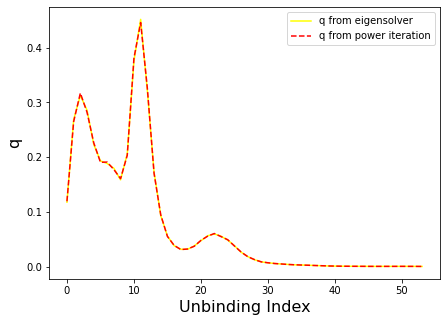

In [12]:
#cl='slategrey'
fig=plt.figure(figsize=[7,5])#facecolor=cl,)
#plt.rcParams['axes.facecolor'] = cl
plt.plot( range(len(q_eigen)), abs(q_eigen), color='yellow', label='q from eigensolver')
plt.plot( range(len(q_power)), q_power, '--',color='r', label='q from power iteration')
plt.legend()    
plt.xlabel('Unbinding Index', fontsize=16)
plt.ylabel('q', fontsize=16)
plt.show()

###  Visualize the potential of mean force (PMF) profile

In [13]:
b=0; f=nM-1

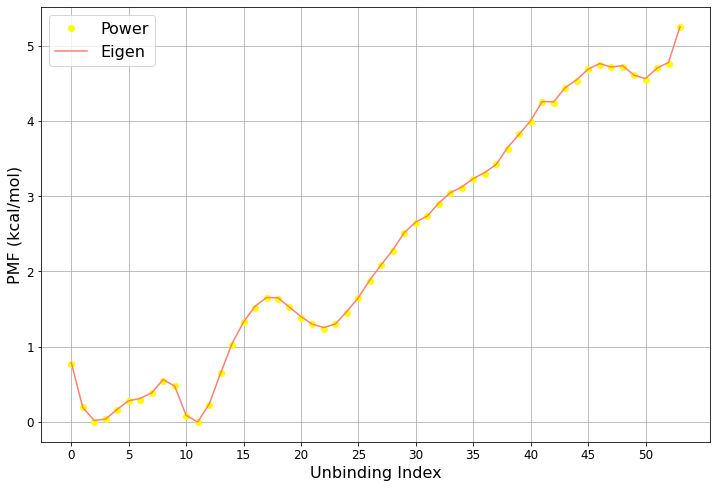

In [15]:
plt.figure(figsize=(12,8))
plt.plot(range(b,f+1), PMF_power, color='yellow', ls='', marker='o' )
plt.plot(range(b,f+1), PMF_eigen, color='salmon')
plt.xlabel('Unbinding Index',fontsize=16)
plt.ylabel('PMF (kcal/mol)', fontsize=16)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=12)
plt.grid()
plt.legend(['Power','Eigen'], fontsize=16)

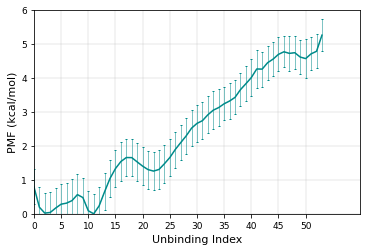

In [16]:
cl='darkcyan'; t_cl = 'brown'
pl_name = 'Cyc-Asp'
fs = 11; lw=.3
PMF = PMF_eigen
fig = plt.figure(figsize = [5.2, 3.6])
plt.plot(range(b,f+1), PMF, ls='--', lw=lw, color=cl)#, marker='o' )
plt.errorbar(range(b, f+1), PMF, F_std,
             color=cl, ecolor=cl,
             elinewidth=0.5, capsize=1)
plt.xlabel('Unbinding Index',fontsize=fs)
plt.ylabel('PMF (kcal/mol)', fontsize=fs)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=fs-2)
plt.xlim([0,60]); plt.ylim([0,6])
plt.grid(lw=lw)

fig.tight_layout()
plt.savefig(pl_name + 'FreeE.pdf')
plt.show()

### Calculate unbinding free energy, $\Delta G$

In [17]:
PMF_eigen = PMF_eigen[0:80] # rm last a few points
b_, f_ = np.argmin(PMF_eigen), np.argmax(PMF_eigen)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_eigen[f_] - PMF_eigen[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 11 and 53:
ΔG =	 -5.252593948760877 kcal/mol


In [20]:
PMF_power = PMF_power[0:80] # rm last a few points
b_, f_ = np.argmin(PMF_power), np.argmax(PMF_power)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_power[f_] - PMF_power[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 3 and 59:
ΔG =	 -4.998289398952811 kcal/mol


###  Calculate MFPT

In [21]:
time = np.array(time)
b = b_; f = f_
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_power[b:f+1]*time[:,1][b:f+1]).sum() / q_power[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)


MFPT from milestone 3 to 59:
MFPT =	 8.782217E-05 ms


In [22]:
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_eigen[b:f+1]*time[:,1][b:f+1]).sum() / q_eigen[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)

MFPT from milestone 3 to 59:
MFPT =	 8.884634E-05 ms
